# Pre-proj: check bias versus trends in multimodel ensemble
## Plot
conda env: `phd_v3` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [3]:
period_past = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
seasons = ['Annual', 'DJFMA', 'JJAS']
# seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

var = 'tas'
table = u.get_table(var)
label, units, levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
label

'Near-Surface Air Temperature'

## Load topography

In [4]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load obs
cru_ts4.00: https://crudata.uea.ac.uk/cru/data/hrg/

In [5]:
obs_longname = 'CRU TS v. 4.00'
obs_name = 'CRU'

obs = xr.open_dataset('/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc').sel(
    time=period_past, lat=latlim_ext, lon=lonlim_ext).tmp

# Check if the time steps are ok
np.testing.assert_equal((int(period_past.stop) - int(period_past.start) + 1)*12, obs.time.size)

## Regrid obs towards the elevation grid of 1°x1°
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [6]:
regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
obs_regrid = regridder(obs)
obs_regrid.attrs['long_name'] = 'Air Temperature'
obs_regrid.attrs['units'] = units

Reuse existing file: bilinear_70x120_35x60.nc


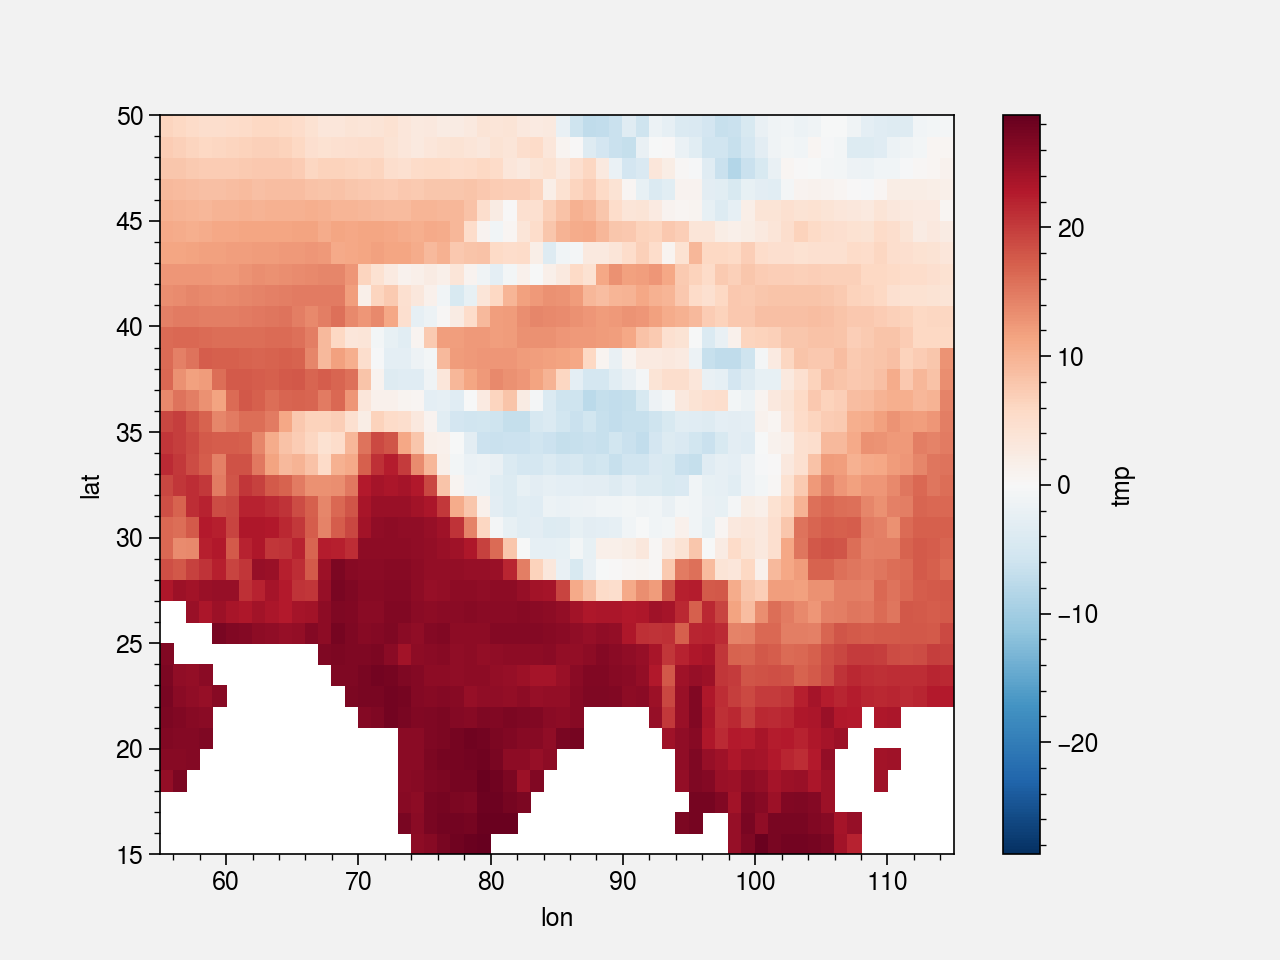

In [9]:
obs_regrid.mean('time').plot()

In [120]:
obs_regrid

<xarray.DataArray 'tmp' (time: 432, lat: 35, lon: 60)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [-12.17459269, -12.44951128, -12.9744294 , ..., -21.97502755,
         -21.59978305, -21.07475626],
        [-13.47464827, -14.09951293, -14.84967533, ..., -22.99989221,
         -21.8997299 , -22.09962144],
        [-14.82470376, -15.39962324, -16.09967716, ..., -23.14962348,
         -23.42448843, -23.52459655]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
...
        [ -3.39972843,  -3.64983709,  -4.09956547, ...,  -8.57513588,
          -7.97486419,  -7.34978269],
        [ -4.07481058,  -4.52475649,  -4.89983769, ...,  -9.89978379,
          -8.29967538,  -8.37464836],
        [ -4.59978466,  -5.12486544,  -5.69983832, ..., -10.17459617,
         -10.02448857,  -9.74962315]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [ -5.37459262,  -5.84972847,  -6.69951104, ..., -17.15021791,
         -16.79994633, -16.47486455],
        [ -6.52470235,  -7.24962118,  -7.87475639, ..., -17.79994606,
         -16.77475696, -17.32459428],
        [ -7.4497307 ,  -8.07486537,  -8.89978462, ..., -17.89951527,
         -18.57443465, -18.89956961]]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-16 1979-02-15 ... 2014-12-16
  * lon      (lon) float32 55.5 56.5 57.5 58.5 59.5 ... 111.5 112.5 113.5 114.5
  * lat      (lat) float32 15.5 16.5 17.5 18.5 19.5 ... 45.5 46.5 47.5 48.5 49.5
Attributes:
    regrid_method:  bilinear
    long_name:      Air Temperature
    units:          °C

## Load models

In [103]:
list_models = u.get_model_names()
list_models = list_models[:10]
list_models

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAS-ESM2-0',
 'CESM2',
 'CESM2-FV2',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1']

In [104]:
list_da = []

for model in list_models:
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    
    path = '/data/mlalande/CMIP6_HMA_paper'
    da = xr.open_dataarray(path+'/'+var+'/'+var+'_'+table+'_'+model+'_historical_ens_'+grid+'_197901-201412_HMA.nc')       
    
    list_da.append(da)

In [30]:
list_da[0]

<xarray.DataArray 'tas' (realization: 3, time: 432, lat: 25, lon: 50)>
[1620000 values with dtype=float64]
Coordinates:
  * time         (time) object 1979-01-16 12:00:00 ... 2014-12-16 12:00:00
  * realization  (realization) object 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
  * lon          (lon) float32 60.5 61.5 62.5 63.5 ... 106.5 107.5 108.5 109.5
  * lat          (lat) float32 20.5 21.5 22.5 23.5 24.5 ... 41.5 42.5 43.5 44.5
Attributes:
    regrid_method:  bilinear

## Compute trends

In [105]:
def corr(x, y, dim):
    return xr.apply_ufunc(
        stats.linregress, x, y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True
    )

In [123]:
# obs
ym_temp = []
for season in seasons:
    # Make annual mean
    ym = u.year_mean(obs_regrid, calendar='standard', season=season)

    # Compute trends
    for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym.year, ym, 'year')):
        ym[arr_name] = arr

    ym_temp.append(ym)

ym_obs = xr.concat(ym_temp, pd.Index(seasons, name='season'))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [109]:
%%time

# model
ym_list = []
ens_list = []

for i, model in enumerate(list_models):
    print(model)
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    
    ym_temp = []
    ens_temp = []
    for season in seasons:
        # Make annual mean
        ym = u.year_mean(list_da[i], calendar=calendar, season=season)
        ens = ym.mean('realization')
        
        # Compute trends
        for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym.year, ym, 'year')):
            ym[arr_name] = arr
            
        for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ens.year, ens, 'year')):
            ens[arr_name] = arr
        
        ym_temp.append(ym)
        ens_temp.append(ens)
        
    concat = xr.concat(ym_temp, pd.Index(seasons, name='season'))
    concat_ens = xr.concat(ens_temp, pd.Index(seasons, name='season'))
    
    ym_list.append(concat)
    ens_list.append(concat_ens)

BCC-CSM2-MR
BCC-ESM1
CAS-ESM2-0
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
CNRM-CM6-1


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


CNRM-CM6-1-HR


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


CNRM-ESM2-1


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


CPU times: user 2min 27s, sys: 1.16 s, total: 2min 28s
Wall time: 2min 30s


In [79]:
# ym_list[0]
ens_list[1]

<xarray.DataArray (season: 3, year: 36, lat: 25, lon: 50)>
array([[[[ 25.2402846 ,  25.18610925,  25.2231206 , ...,  24.28212177,
           24.82673624,  24.89221902],
         [ 25.56217904,  25.33611415,  25.3078603 , ...,  22.1269059 ,
           22.7258815 ,  22.90210974],
         [ 25.94513899,  25.64069796,  25.54080596, ...,  20.16611028,
           20.59377207,  20.72321736],
         ...,
         [ 12.23998849,  12.21913231,  12.13796746, ...,   3.8329755 ,
            3.72388921,   3.46333588],
         [ 11.47114596,  11.51857704,  11.45112422, ...,   3.14315992,
            3.19644991,   3.1211328 ],
         [ 10.81280469,  10.72420332,  10.83670276, ...,   2.29701829,
            2.43053468,   2.42341538]],

        [[ 24.93010104,  24.87557111,  24.92872857, ...,  23.78955863,
           24.35818563,  24.44065993],
         [ 25.21086241,  25.00381778,  24.99805746, ...,  21.80892771,
           22.47634121,  22.62070277],
         [ 25.57866089,  25.2861693 ,  25.21467031, ...,  20.03353109,
           20.57858737,  20.68543242],
...
         [ 28.10578107,  28.15845102,  28.01518534, ...,  20.57503095,
           20.49026707,  20.14220029],
         [ 27.63342138,  27.72459238,  27.56603887, ...,  20.0585879 ,
           20.31707673,  20.34014263],
         [ 27.38856687,  27.15137687,  27.27736104, ...,  19.20803897,
           19.67932592,  19.94911757]],

        [[ 26.2602613 ,  26.23620639,  26.40573225, ...,  29.28747957,
           29.63728626,  29.7744555 ],
         [ 27.59319918,  26.89840207,  26.87229665, ...,  28.80084595,
           29.28766423,  29.40179016],
         [ 28.79433469,  27.94691293,  27.69265851, ...,  28.08646567,
           28.66659324,  28.79710993],
         ...,
         [ 27.80185161,  27.78200373,  27.59345617, ...,  20.74959838,
           20.7663765 ,  20.53692532],
         [ 27.45978916,  27.47426971,  27.24681335, ...,  20.25834901,
           20.56014657,  20.64961504],
         [ 27.37021867,  27.05775579,  27.10123338, ...,  19.6084016 ,
           20.1089951 ,  20.37301899]]]])
Coordinates:
  * lat        (lat) float32 20.5 21.5 22.5 23.5 24.5 ... 41.5 42.5 43.5 44.5
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2011 2012 2013 2014
  * lon        (lon) float32 60.5 61.5 62.5 63.5 ... 106.5 107.5 108.5 109.5
    slope      (season, lat, lon) float64 0.01553 0.01584 ... 0.04783 0.04725
    intercept  (season, lat, lon) float64 -5.649 -6.321 -6.931 ... -76.67 -75.3
    rvalue     (season, lat, lon) float64 0.7088 0.7104 0.7054 ... 0.7571 0.7531
    pvalue     (season, lat, lon) float64 1.316e-06 1.214e-06 ... 1.161e-07
    stderr     (season, lat, lon) float64 0.002652 0.002692 ... 0.00708 0.007079
  * season     (season) object 'Annual' 'DJFMA' 'JJAS'

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/proplot/axes/plot.py:2684: UserWarning: Warning: converting a masked element to nan.
  vmin = float(data.min())
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/proplot/axes/plot.py:2686: UserWarning: Warning: converting a masked element to nan.
  vmax = float(data.max())
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


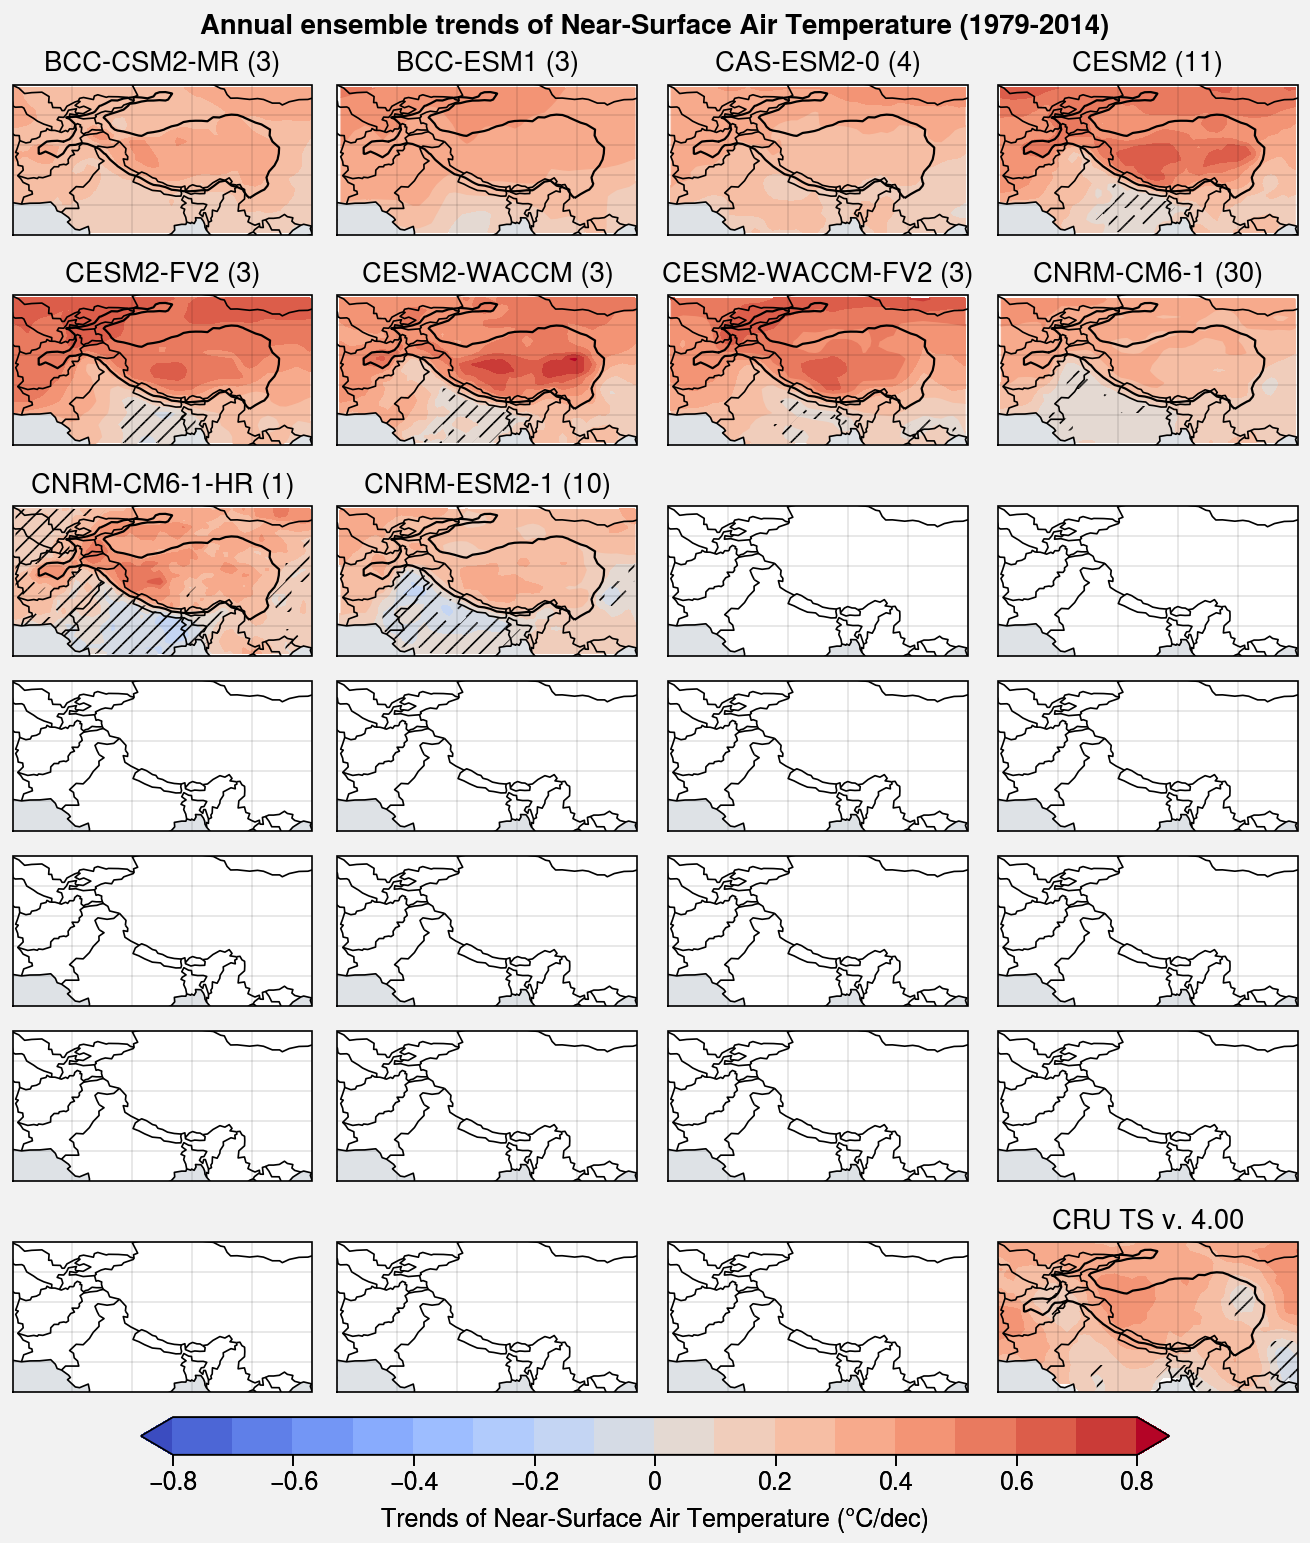

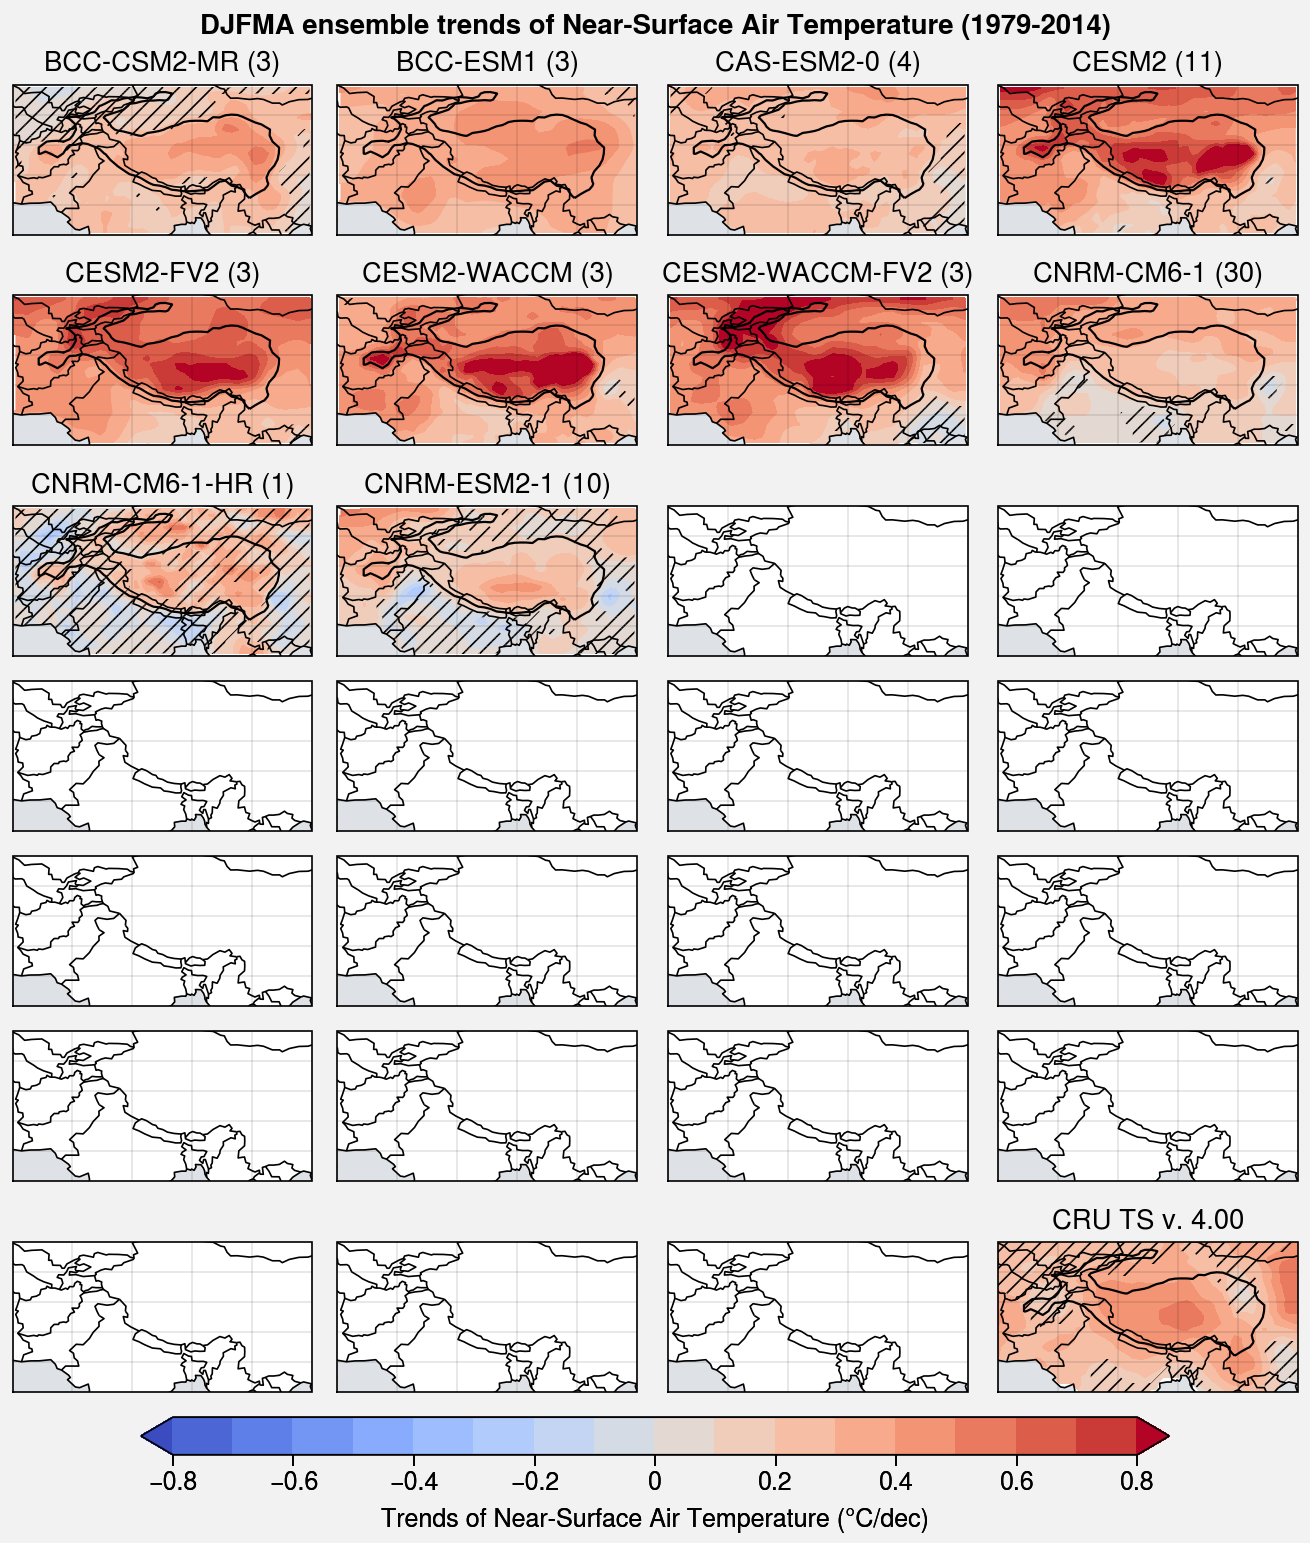

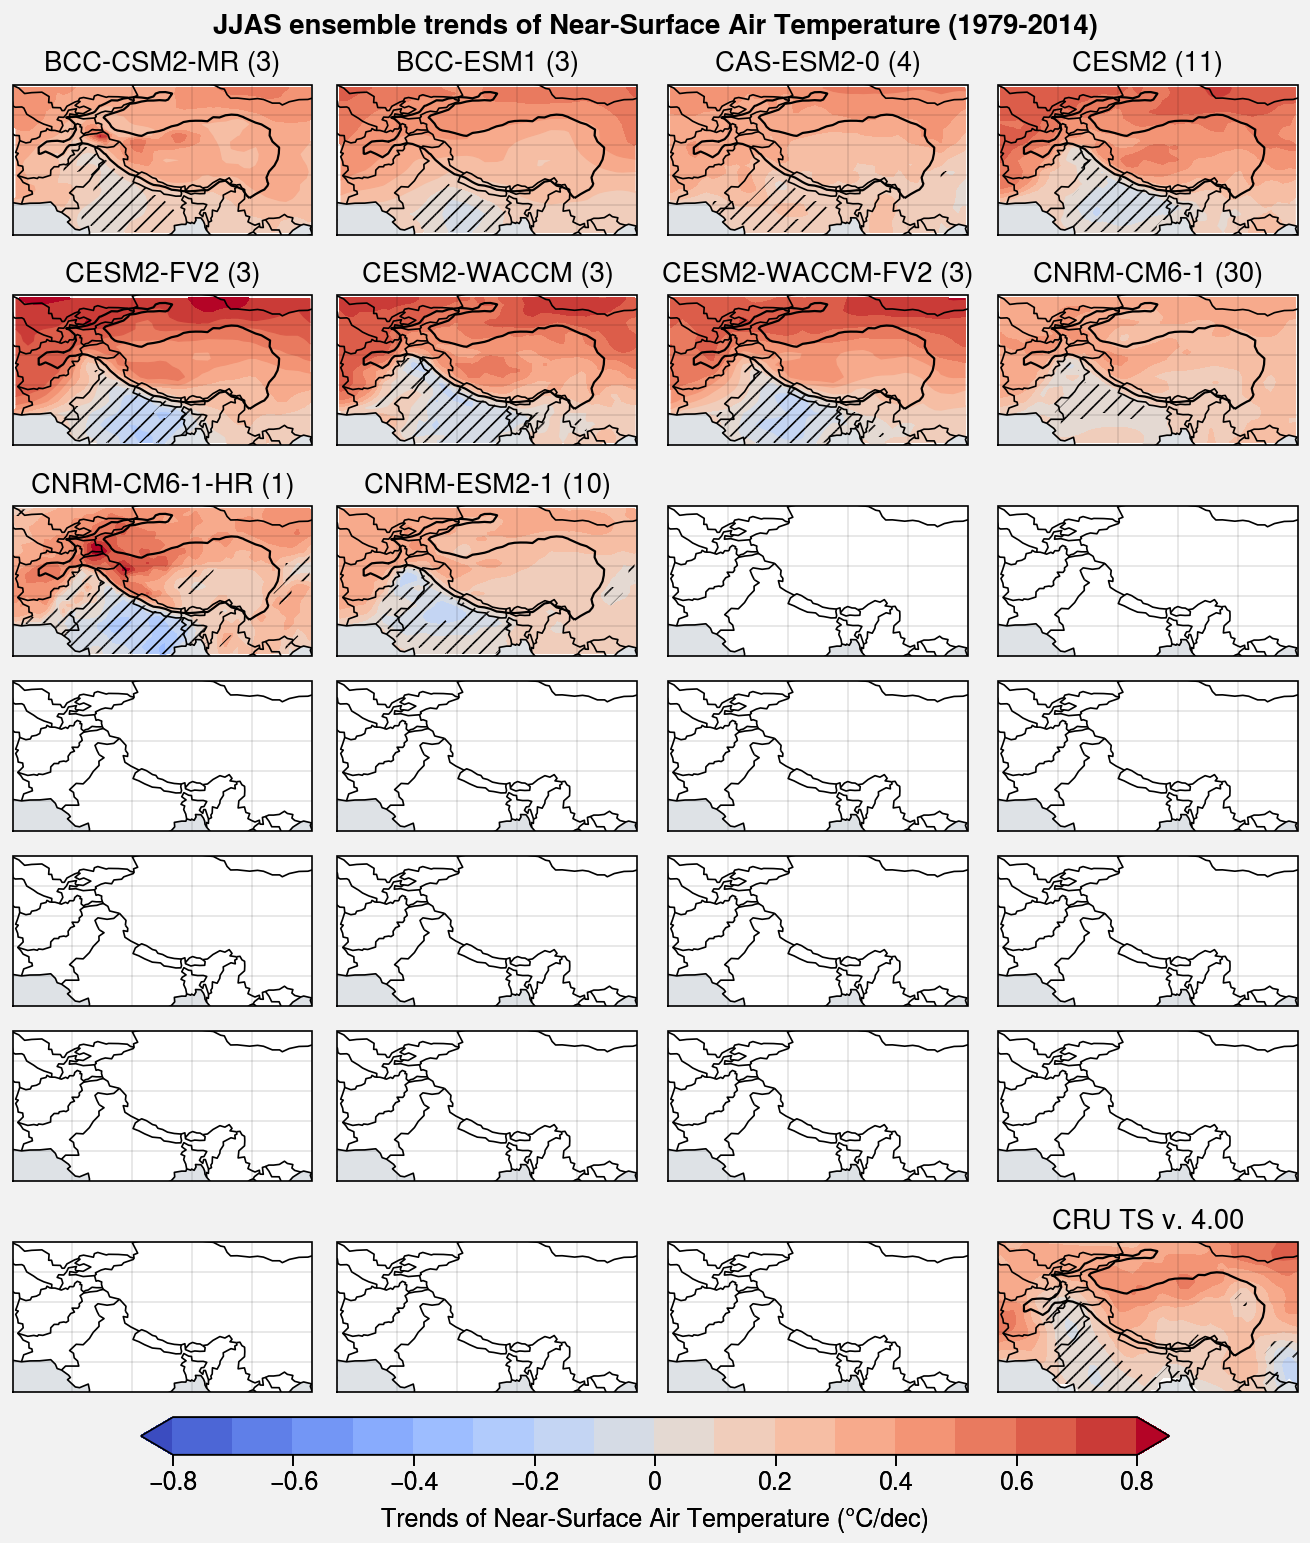

In [129]:
cmap = 'CoolWarm'
levels = plot.arange(-0.8,0.8,0.1)
extend = 'both'

for season in seasons:
# for season in ['Annual']:
    f, axs = plot.subplots(proj='cyl', ncols=4, nrows=7, axwidth=1.5)
    
    # Plot observation
    last = len(axs)-1
    axs[last].contour(elevation, levels=[2500], color='black', linewidth=0.8)
    m = axs[last].contourf(
        ym_obs.sel(season=season).slope*10, cmap=cmap, levels=levels, extend=extend
    )
    pvalue = ym_obs.sel(season=season).pvalue
    axs[last].contourf(pvalue.where(pvalue>0.05), hatches=['////'], alpha=0)
    axs[last].format(title=obs_longname)
    
    for i, model in enumerate(list_models):
        # Add contour 2500 m
        axs[i].contour(elevation, levels=[2500], color='black', linewidth=0.8)

        # Plot model bias
        m = axs[i].contourf(
            ens_list[i].sel(season=season).slope*10, cmap=cmap, levels=levels, extend=extend
        )
        
        # pvalue
        pvalue = ens_list[i].sel(season=season).pvalue
        axs[i].contourf(pvalue.where(pvalue>0.05), hatches=['////'], alpha=0)

        # Text
        axs[i].format(title=model+' ('+str(ym_list[i].realization.size)+')')

    f.colorbar(m, label='Trends of '+label+' ('+units+'/dec)', loc='b', length=0.8)

    axs.format(
        # Grids, labels and limits
        labels=False, lonlines=10, latlines=5, 
        latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
        
        # Add coast, ocean, borders
        coast=True, ocean=True, oceancolor='gray3', borders=True,
        
        # Suptitle
        suptitle=season+' ensemble trends of '+label+' ('+period_past.start+'-'+period_past.stop+')'   
    )
    
    filename = season+'_trends_'+var+'_'+period_past.start+'-'+period_past.stop
    f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

In [26]:
def corr(x, y, dim):
    return xr.apply_ufunc(
        stats.linregress, x, y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True
    )

In [27]:
ym = u.year_mean(da_past_regrid)
ym.load()
for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym.year, ym, 'year')):
    ym[arr_name] = arr

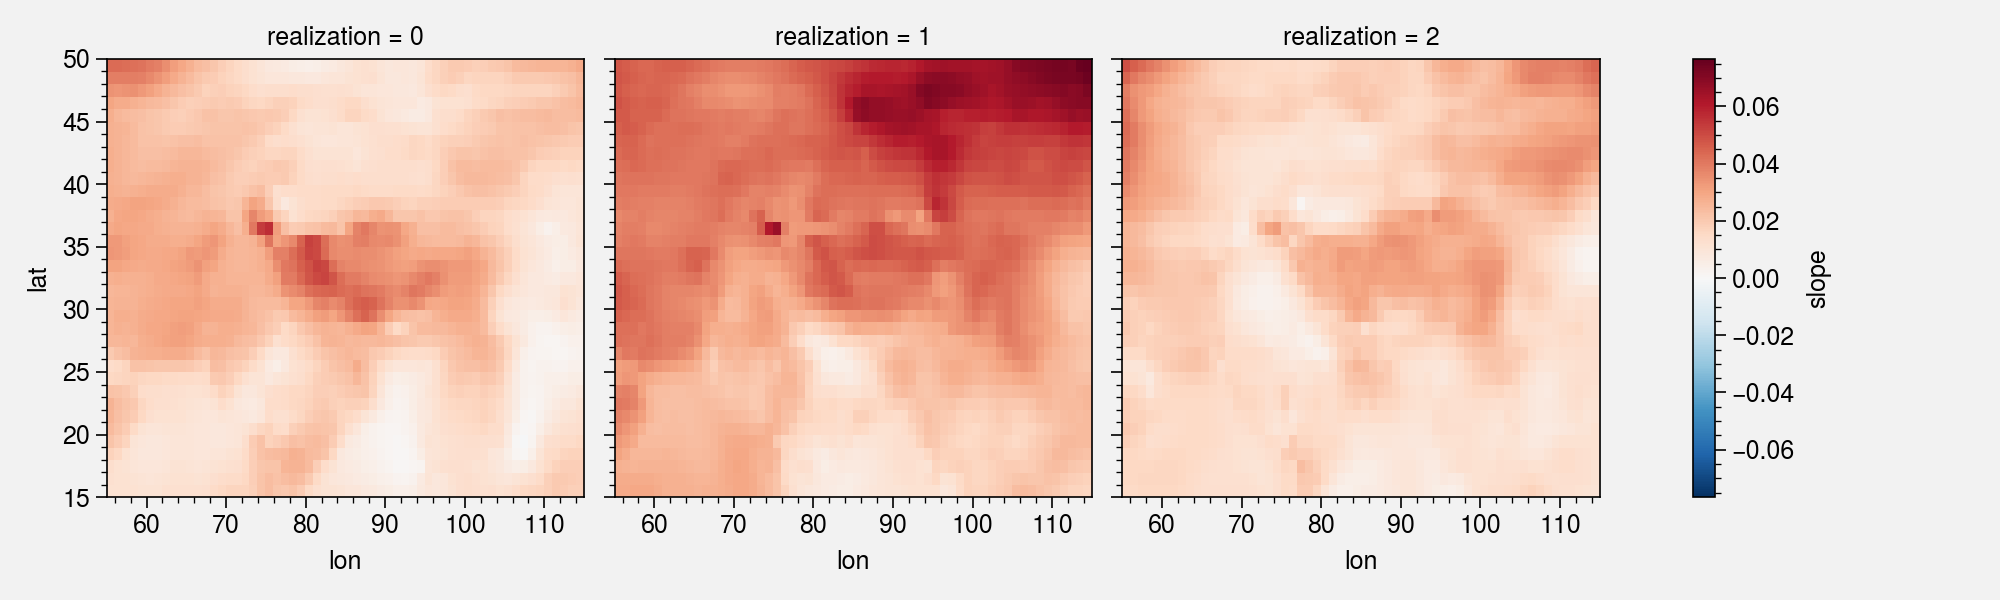

In [30]:
ym.slope.plot(col='realization')

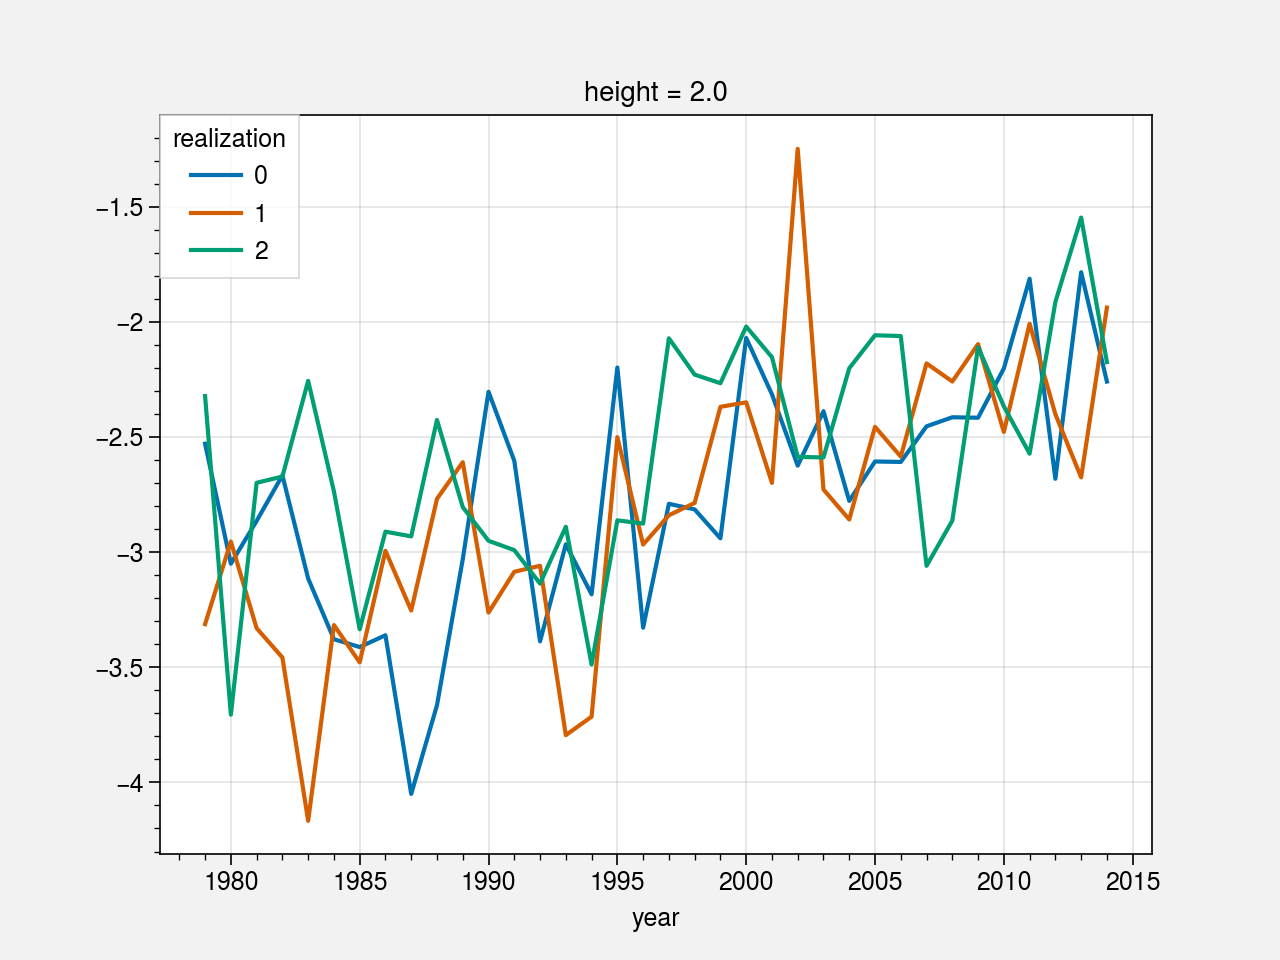

In [20]:
da_past_ym.plot(hue='realization')

In [10]:
'/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest'

'/bdd/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Amon/tas/gn/latest'

In [12]:
!ls /bdd/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Amon/tas/gn/latest

tas_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc


In [13]:
xr.open_dataset('/bdd/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Amon/tas/gn/latest/tas_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc')

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 160, lon: 320, time: 1980)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  2289.0
    comment:                The model integration starts from the piControl e...
    contact:                Dr. Tongwen Wu(twwu@cma.gov.cn)
    creation_date:          2018-11-26T05:08:26Z
    data_specs_version:     01.00.27
    description:            DECK: historical
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.BCC.BCC-CSM2...
    grid:                   T106
    grid_label:             gn
    history:                2018-11-26T05:08:26Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            Beijing Climate Center, Beijing 100081, China
    institution_id:         BCC
    mip_era:                CMIP6
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       BCC-CSM2-MR
    parent_time_units:      days since 1850-01-01
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos
    references:             Model described by Tongwen Wu et al. (JGR 2013; J...
    run_variant:            forcing: greenhouse gases,solar constant,aerosol,...
    source:                 BCC-CSM 2 MR (2017):   aerosol: none  atmos: BCC_...
    source_id:              BCC-CSM2-MR
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Amon
    table_info:             Creation Date:(30 July 2018) MD5:e53ff52009d0b97d...
    title:                  BCC-CSM2-MR output prepared for CMIP6
    tracking_id:            hdl:21.14100/007da5e5-12bb-4fe9-8df9-5cd473280650
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by BCC is licensed unde...
    cmor_version:           3.3.2

In [15]:
xr.open_dataset('/bdd/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r3i1p1f1/Amon/tas/gn/latest/tas_Amon_BCC-CSM2-MR_historical_r3i1p1f1_gn_185001-201412.nc')

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 160, lon: 320, time: 1980)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  2439.0
    comment:                The model integration starts from the piControl e...
    contact:                Dr. Tongwen Wu(twwu@cma.gov.cn)
    creation_date:          2018-11-19T03:26:44Z
    data_specs_version:     01.00.27
    description:            DECK: historical
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.BCC.BCC-CSM2...
    grid:                   T106
    grid_label:             gn
    history:                2018-11-19T03:26:44Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            Beijing Climate Center, Beijing 100081, China
    institution_id:         BCC
    mip_era:                CMIP6
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       BCC-CSM2-MR
    parent_time_units:      days since 1850-01-01
    parent_variant_label:   r3i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      3
    realm:                  atmos
    references:             Model described by Tongwen Wu et al. (JGR 2013; J...
    run_variant:            forcing: greenhouse gases,solar constant,aerosol,...
    source:                 BCC-CSM 2 MR (2017):   aerosol: none  atmos: BCC_...
    source_id:              BCC-CSM2-MR
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Amon
    table_info:             Creation Date:(30 July 2018) MD5:e53ff52009d0b97d...
    title:                  BCC-CSM2-MR output prepared for CMIP6
    tracking_id:            hdl:21.14100/54ec9725-f5a0-4ac2-b828-844a72371e11
    variable_id:            tas
    variant_label:          r3i1p1f1
    license:                CMIP6 model data produced by BCC is licensed unde...
    cmor_version:           3.3.2

In [8]:
# '/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/'

## Concatenate results by zones and scenarios

In [9]:
%%time
# Model past
temp = [None]*len(seasons)
for k, season in enumerate(seasons):
    temp[k] = xr.concat(
        da_past_ym_list[k][:], pd.Index(list_models, name='model'), coords='minimal', compat='override'
    )
mm_past_ym = xr.concat(temp, pd.Index(seasons, name="season"))

temp = [None]*len(zones) 
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        mm_past_ym.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )
mm_past_ym_zones = xr.concat(temp, pd.Index(zones, name="zone")).load()

CPU times: user 170 ms, sys: 29 ms, total: 199 ms
Wall time: 279 ms


In [26]:
# mm_past_ym_zones.model
# mm_past_ym_zones

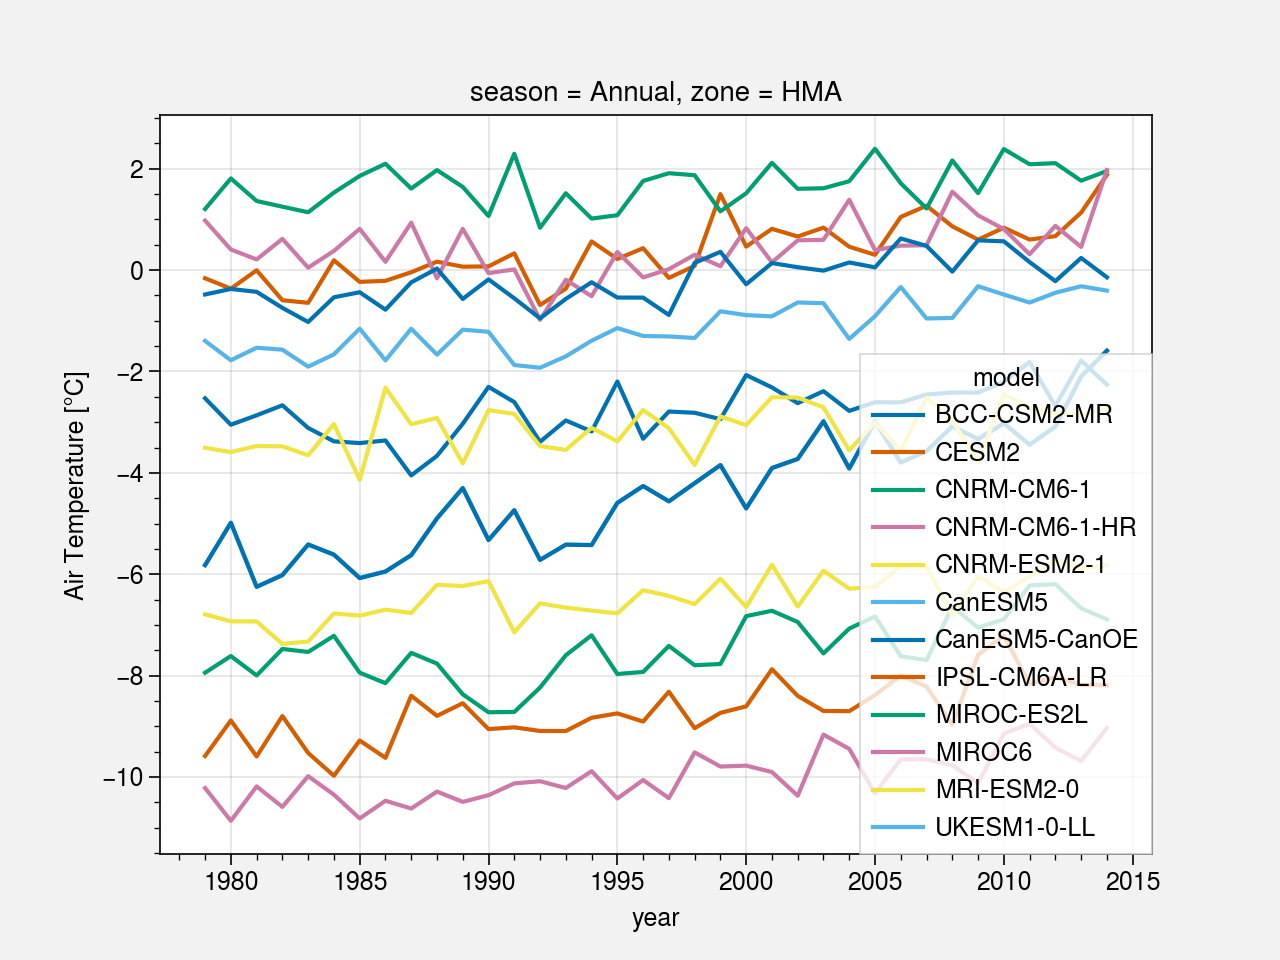

In [10]:
mm_past_ym_zones.sel(season='Annual', zone='HMA').plot(hue='model')
obs_ym_regrid_zones.sel(season='Annual', zone='HMA').plot()

In [11]:
period_past

slice('1979', '2014', None)

## Compute trends

### HMA

In [10]:
indexes = list_models.copy()
indexes.append('Observation')
zone = 'HMA'

df = pd.DataFrame(
    columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'bias'],
    index=indexes
)

for model in list_models:
    
    # Linear regression of the bias
    x = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).year
    y = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).values
    df.loc[model][:5] = stats.linregress(x, y)
    
    # Compute the mean bias
    df.loc[model]['bias'] = (mm_past_ym_zones.sel(season='Annual', zone=zone, model=model).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    

# obs
# Linear regression of the bias
x = obs_ym_regrid_zones.sel(season='Annual', zone=zone).year
y = obs_ym_regrid_zones.sel(season='Annual', zone=zone).values
df.loc['Observation'][:5] = stats.linregress(x, y)

# Compute the mean bias
df.loc['Observation']['bias'] = (obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    
df = df.drop(columns=['intercept', 'rvalue'])
df.slope = df.slope*10 
df.astype(float).round(2)

slope  pvalue  stderr  bias
BCC-CSM2-MR     0.30    0.00    0.01 -2.55
CESM2           0.45    0.00    0.01  0.55
CNRM-CM6-1      0.40    0.00    0.01 -7.27
CNRM-CM6-1-HR   0.35    0.00    0.01 -9.81
CNRM-ESM2-1     0.31    0.00    0.00 -6.25
CanESM5         1.03    0.00    0.01 -4.20
CanESM5-CanOE   1.03    0.00    0.01 -4.20
IPSL-CM6A-LR    0.43    0.00    0.01 -8.50
MIROC-ES2L      0.15    0.02    0.01  1.86
MIROC6          0.20    0.03    0.01  0.65
MRI-ESM2-0      0.18    0.01    0.01 -2.93
UKESM1-0-LL     0.39    0.00    0.00 -0.94
Observation     0.29    0.00    0.01  0.00

### HK

In [11]:
indexes = list_models.copy()
indexes.append('Observation')
zone = 'HK'

df = pd.DataFrame(
    columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'bias'],
    index=indexes
)

for model in list_models:
    
    # Linear regression of the bias
    x = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).year
    y = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).values
    df.loc[model][:5] = stats.linregress(x, y)
    
    # Compute the mean bias
    df.loc[model]['bias'] = (mm_past_ym_zones.sel(season='Annual', zone=zone, model=model).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    

# obs
# Linear regression of the bias
x = obs_ym_regrid_zones.sel(season='Annual', zone=zone).year
y = obs_ym_regrid_zones.sel(season='Annual', zone=zone).values
df.loc['Observation'][:5] = stats.linregress(x, y)

# Compute the mean bias
df.loc['Observation']['bias'] = (obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    
df = df.drop(columns=['intercept', 'rvalue'])
df.slope = df.slope*10 
df.astype(float).round(2)

slope  pvalue  stderr   bias
BCC-CSM2-MR     0.33    0.00    0.01  -4.67
CESM2           0.44    0.00    0.01  -1.67
CNRM-CM6-1      0.48    0.00    0.01 -10.09
CNRM-CM6-1-HR   0.46    0.00    0.01 -13.60
CNRM-ESM2-1     0.31    0.00    0.01  -8.98
CanESM5         0.88    0.00    0.01  -5.60
CanESM5-CanOE   0.88    0.00    0.01  -5.60
IPSL-CM6A-LR    0.49    0.00    0.01 -11.56
MIROC-ES2L      0.37    0.00    0.01   3.98
MIROC6          0.28    0.01    0.01  -0.76
MRI-ESM2-0      0.14    0.15    0.01  -5.64
UKESM1-0-LL     0.49    0.00    0.01  -3.00
Observation     0.33    0.00    0.01   0.00

### HM

In [12]:
indexes = list_models.copy()
indexes.append('Observation')
zone = 'HM'

df = pd.DataFrame(
    columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'bias'],
    index=indexes
)

for model in list_models:
    
    # Linear regression of the bias
    x = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).year
    y = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).values
    df.loc[model][:5] = stats.linregress(x, y)
    
    # Compute the mean bias
    df.loc[model]['bias'] = (mm_past_ym_zones.sel(season='Annual', zone=zone, model=model).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    

# obs
# Linear regression of the bias
x = obs_ym_regrid_zones.sel(season='Annual', zone=zone).year
y = obs_ym_regrid_zones.sel(season='Annual', zone=zone).values
df.loc['Observation'][:5] = stats.linregress(x, y)

# Compute the mean bias
df.loc['Observation']['bias'] = (obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    
df = df.drop(columns=['intercept', 'rvalue'])
df.slope = df.slope*10 
df.astype(float).round(2)

slope  pvalue  stderr  bias
BCC-CSM2-MR     0.31    0.00    0.01 -1.43
CESM2           0.39    0.00    0.01  0.65
CNRM-CM6-1      0.30    0.00    0.01 -6.72
CNRM-CM6-1-HR   0.29    0.00    0.01 -9.86
CNRM-ESM2-1     0.27    0.00    0.01 -5.93
CanESM5         1.02    0.00    0.01 -2.61
CanESM5-CanOE   1.02    0.00    0.01 -2.61
IPSL-CM6A-LR    0.41    0.00    0.01 -8.09
MIROC-ES2L      0.02    0.82    0.01  3.10
MIROC6          0.20    0.09    0.01  0.88
MRI-ESM2-0      0.14    0.06    0.01 -2.77
UKESM1-0-LL     0.34    0.00    0.01  0.12
Observation     0.29    0.00    0.01  0.00

### TP

In [13]:
indexes = list_models.copy()
indexes.append('Observation')
zone = 'TP'

df = pd.DataFrame(
    columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'bias'],
    index=indexes
)

for model in list_models:
    
    # Linear regression of the bias
    x = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).year
    y = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).values
    df.loc[model][:5] = stats.linregress(x, y)
    
    # Compute the mean bias
    df.loc[model]['bias'] = (mm_past_ym_zones.sel(season='Annual', zone=zone, model=model).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    

# obs
# Linear regression of the bias
x = obs_ym_regrid_zones.sel(season='Annual', zone=zone).year
y = obs_ym_regrid_zones.sel(season='Annual', zone=zone).values
df.loc['Observation'][:5] = stats.linregress(x, y)

# Compute the mean bias
df.loc['Observation']['bias'] = (obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    
df = df.drop(columns=['intercept', 'rvalue'])
df.slope = df.slope*10 
df.astype(float).round(2)

slope  pvalue  stderr  bias
BCC-CSM2-MR     0.32    0.00    0.01 -3.14
CESM2           0.49    0.00    0.01  0.89
CNRM-CM6-1      0.39    0.00    0.01 -7.52
CNRM-CM6-1-HR   0.35    0.00    0.01 -9.24
CNRM-ESM2-1     0.32    0.00    0.01 -6.39
CanESM5         1.24    0.00    0.01 -5.42
CanESM5-CanOE   1.24    0.00    0.01 -5.42
IPSL-CM6A-LR    0.42    0.00    0.01 -8.90
MIROC-ES2L      0.07    0.24    0.01 -0.91
MIROC6          0.17    0.08    0.01 -0.35
MRI-ESM2-0      0.20    0.01    0.01 -2.58
UKESM1-0-LL     0.34    0.00    0.01 -0.94
Observation     0.28    0.00    0.01  0.00

## Check CanESM5

In [10]:
path = '/bdd/CMIP6/CMIP/CCCma/CanESM5/historical/r*i1p1f1/Amon/tas/gn/latest/tas_Amon_CanESM5_historical_r*i1p1f1_gn_185001-201412.nc'

ds = xr.open_mfdataset(path, combine='nested', concat_dim='realization').sel(time=period_past, lat=latlim_ext, lon=lonlim_ext).tas
ds

<xarray.DataArray 'tas' (realization: 25, time: 432, lat: 13, lon: 21)>
dask.array<getitem, shape=(25, 432, 13, 21), dtype=float32, chunksize=(1, 432, 13, 21), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 56.25 59.06 61.88 64.69 ... 104.1 106.9 109.7 112.5
  * lat      (lat) float64 15.35 18.14 20.93 23.72 ... 40.46 43.25 46.04 48.84
  * time     (time) object 1979-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: realization
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        ST+273.16, CMIP_table_comment: near-surface (usually, 2 m...
    units:          K
    original_name:  ST
    history:        degctok 2019-04-30T17:40:12Z altered by CMOR: Treated sca...
    cell_methods:   area: time: mean
    cell_measures:  area: areacella

In [11]:
# tas (K -> °C)
#################################################################################

ds -= 273.15

#################################################################################

# Make year_mean
ds_ym = u.year_mean(ds)

# Regrid
regridder = xe.Regridder(ds_ym, elevation, 'bilinear', periodic=False, reuse_weights=True)
ds_ym_regrid = regridder(ds_ym)

Reuse existing file: bilinear_13x21_35x60.nc


In [12]:
ds_ave_tas = u.spatial_average(ds_ym_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500))
ds_ave_tas

<xarray.DataArray (realization: 25, year: 36)>
dask.array<sum-aggregate, shape=(25, 36), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2010 2011 2012 2013 2014
Dimensions without coordinates: realization
Attributes:
    regrid_method:  bilinear

## Check snc

In [14]:
path = '/bdd/CMIP6/CMIP/CCCma/CanESM5/historical/r*i1p1f1/LImon/snc/gn/latest/snc_LImon_CanESM5_historical_r*i1p1f1_gn_185001-201412.nc'

ds = xr.open_mfdataset(path, combine='nested', concat_dim='realization').sel(time=period_past, lat=latlim_ext, lon=lonlim_ext).snc
ds

<xarray.DataArray 'snc' (realization: 25, time: 432, lat: 13, lon: 21)>
dask.array<getitem, shape=(25, 432, 13, 21), dtype=float32, chunksize=(1, 432, 13, 21), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 56.25 59.06 61.88 64.69 ... 104.1 106.9 109.7 112.5
  * lat      (lat) float64 15.35 18.14 20.93 23.72 ... 40.46 43.25 46.04 48.84
  * time     (time) object 1979-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: realization
Attributes:
    standard_name:  surface_snow_area_fraction
    long_name:      Snow Area Percentage
    comment:        FNT(1)*FARE(1), CMIP_table_comment: Fraction of each grid...
    units:          %
    original_name:  FN
    history:        mltby100 2019-04-30T23:05:07Z altered by CMOR: Reordered ...
    cell_methods:   area: time: mean
    cell_measures:  area: areacella

In [15]:
# Make year_mean
ds_ym = u.year_mean(ds)

# Regrid
regridder = xe.Regridder(ds_ym, elevation, 'bilinear', periodic=False, reuse_weights=True)
ds_ym_regrid = regridder(ds_ym)

Reuse existing file: bilinear_13x21_35x60.nc


In [16]:
ds_ave_snc = u.spatial_average(ds_ym_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500))
ds_ave_snc

<xarray.DataArray (realization: 25, year: 36)>
dask.array<sum-aggregate, shape=(25, 36), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2010 2011 2012 2013 2014
Dimensions without coordinates: realization
Attributes:
    regrid_method:  bilinear

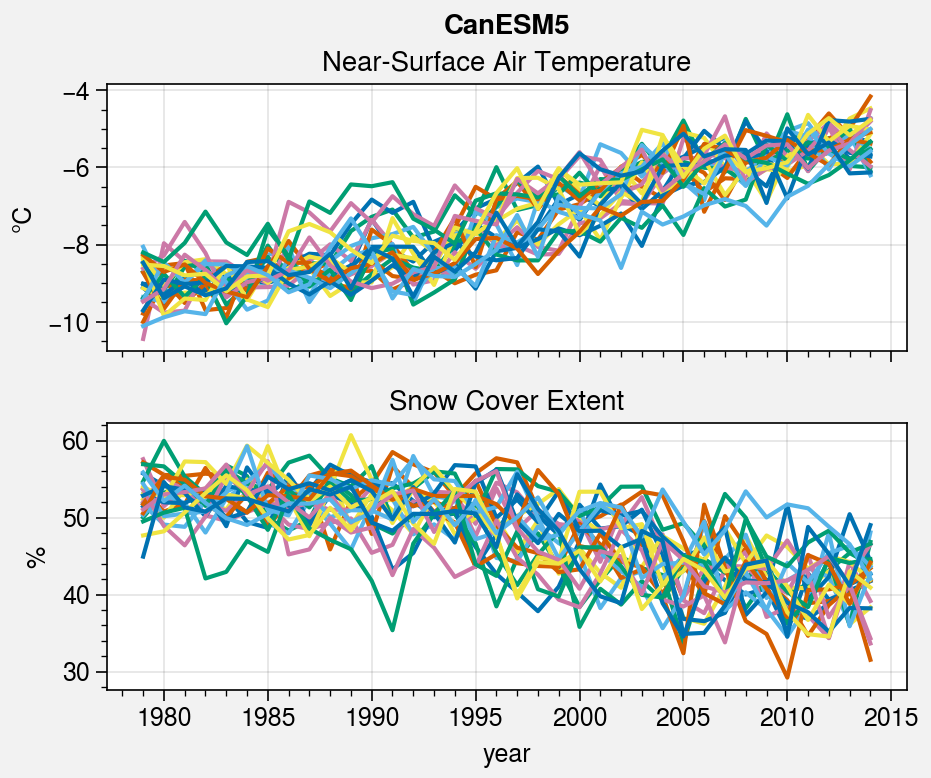

In [61]:
f, axs = plot.subplots(ncols=1, nrows=2, sharey=0, aspect=3, axwidth=4)

for i in range(ds_ave_tas.realization.size):
# for i in range(1):
    axs[0].plot(ds_ave_tas.isel(realization=i))
    axs[1].plot(ds_ave_snc.isel(realization=i))

axs[0].format(title='Near-Surface Air Temperature')
axs[1].format(title='Snow Cover Extent')

axs[0].format(ylabel='°C')
axs[1].format(ylabel='%')

axs.format(
    suptitle='CanESM5'
)

f.save('img/CanESM5_timeseries_snc_tas_ensemble.jpg')

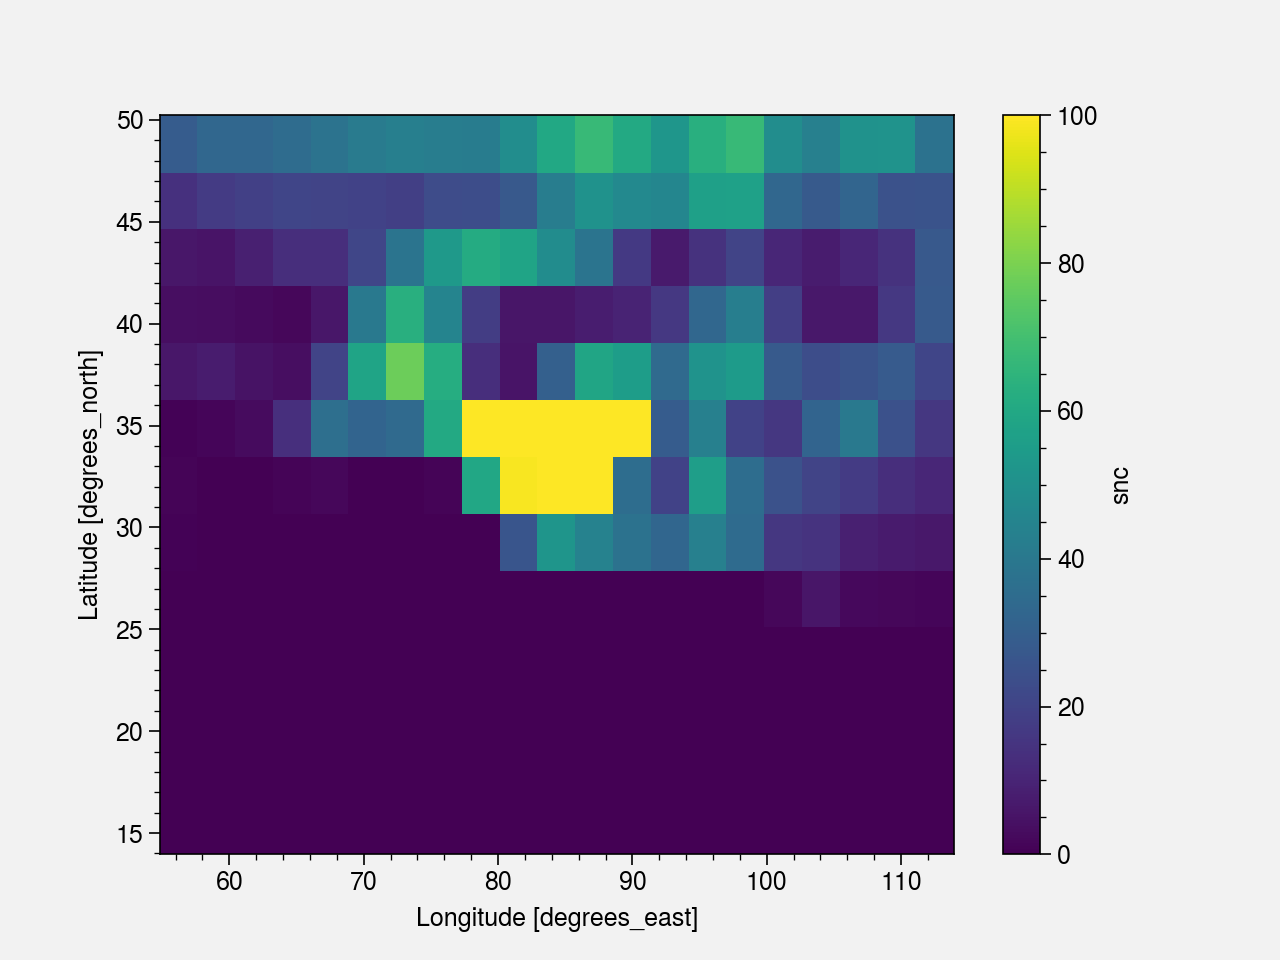

In [86]:
ds[0].sel(time=slice('1979','1990')).mean('time').plot()

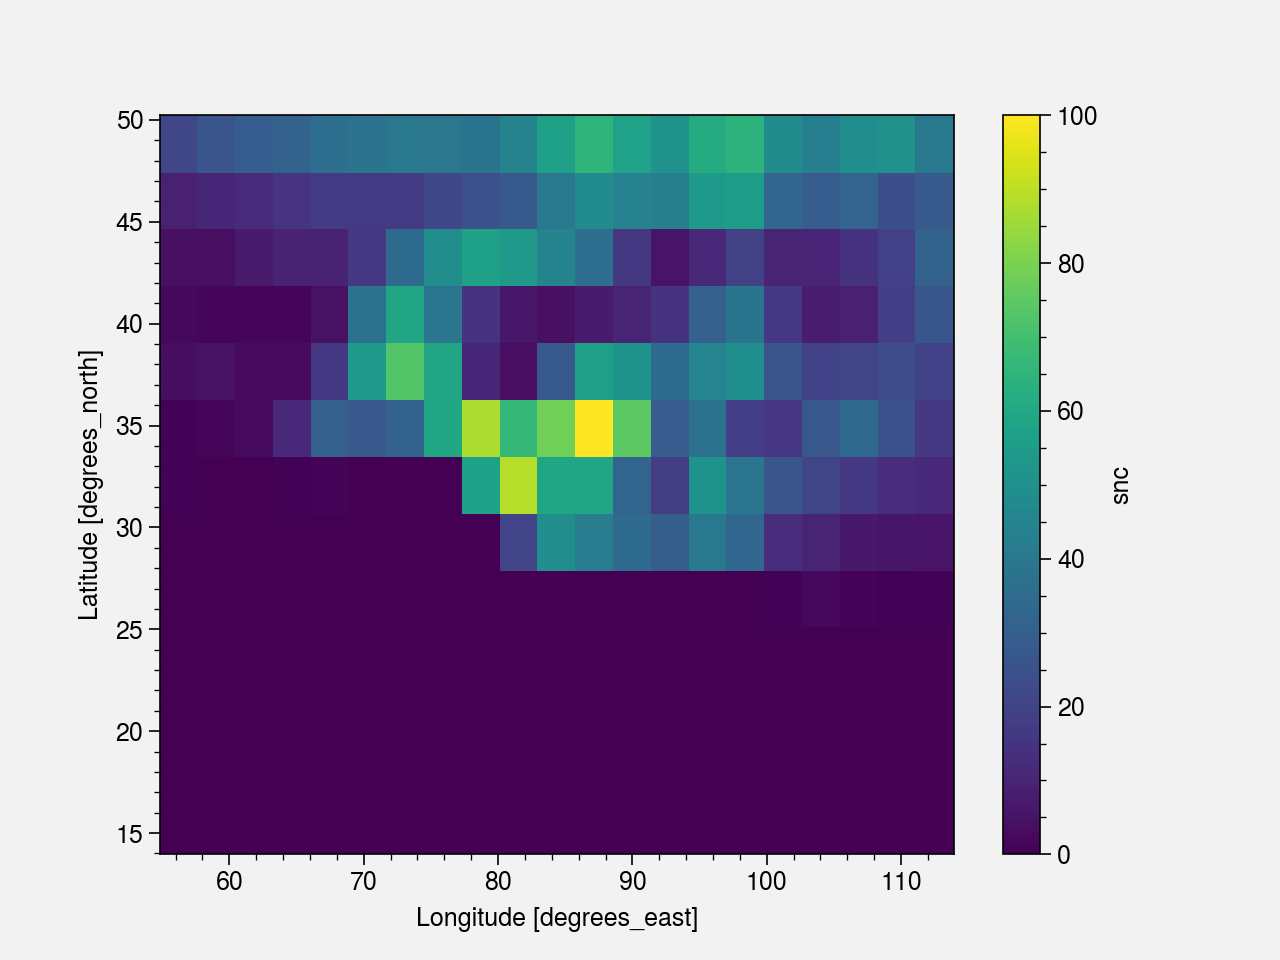

In [87]:
ds[0].sel(time=slice('1990','2014')).mean('time').plot()

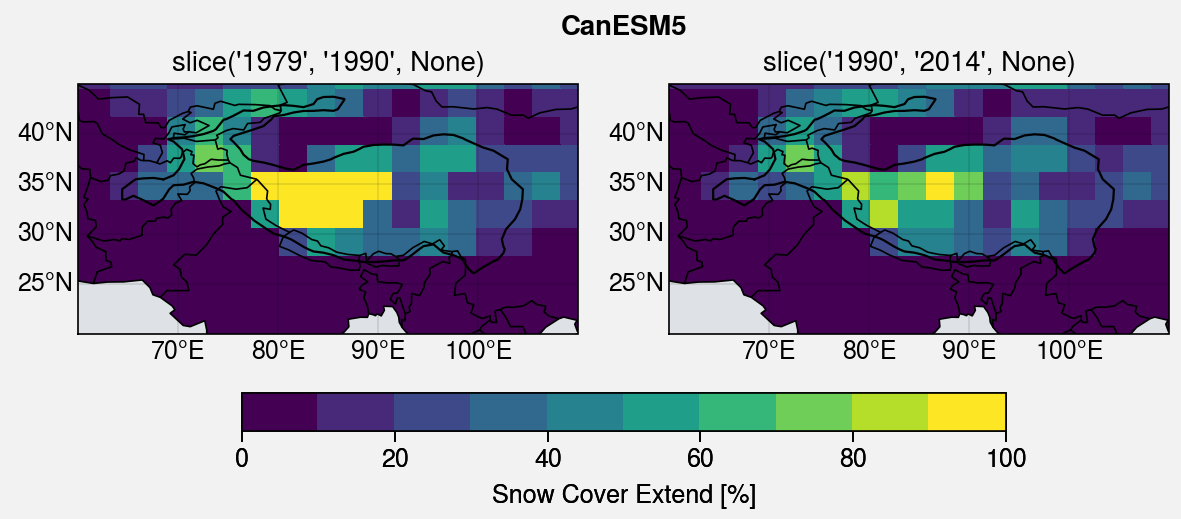

In [99]:
f, axs = plot.subplots(proj='cyl', ncols=2, nrows=1)

for i, period in enumerate([slice('1979','1990'), slice('1990','2014')]):
    # Add contour 2500 m
    axs[i].contour(elevation, levels=[2500], color='black', linewidth=0.8)

    norm = plot.Norm('diverging', fair=False)
    
    # Plot observation
    m = axs[i].pcolormesh(
        ds[0].sel(time=period).mean('time'), cmap='viridis', 
        levels=plot.arange(0,100,10), 
        extend='neither'
    )
    axs[i].format(title=period)


f.colorbar(m, label = 'Snow Cover Extend [%]', loc='b', length=0.7)

axs.format(
    # Grids, labels and limits
    labels=True, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),

    # Add coast, ocean, borders
    coast=True, ocean=True, oceancolor='gray3', borders=True,

    # Suptitle
    suptitle='CanESM5' 
)

filename = 'CanESM5_snc'
f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

## Load future
To check if CanESM stays higher than others (climate sensitivity too big) or if it starts to stabialize, what could suggest a strong answer to snow melt around 1990.

['BCC-CSM2-MR',
 'CESM2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'CanESM5-CanOE',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

In [24]:
period_future = slice('2015','2100')
scenario = 'ssp585'

list_models = u.get_model_names_projections()
list_models.remove('CESM2')
# list_models = list_models[:1]
# list_models = ['EC-Earth3']

da_future_ym_list = [[None] * (len(list_models)) for i in range(len(seasons))]

for i, model in enumerate(list_models):
    print(model + ' ('+str(i+1)+'/'+str(len(list_models))+')')
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    
    #################
    ### Load ssp585 ###
    #################
    if model in ['IPSL-CM6A-LR', 'MRI-ESM2-0']:
        da_future = xr.open_mfdataset(
            '/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*210012.nc', 
            combine='by_coords').sel(time=period_future, lat=latlim_ext, lon=lonlim_ext)[var]
    else:
        da_future = xr.open_mfdataset(
            '/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
            combine='by_coords').sel(time=period_future, lat=latlim_ext, lon=lonlim_ext)[var]
    
    np.testing.assert_equal((int(period_future.stop) - int(period_future.start) + 1)*12, da_future.time.size)
    
    # tas (K -> °C)
    #################################################################################

    da_future -= 273.15
        
    #################################################################################
    
    for k, season in enumerate(seasons):
        # Make year_mean
        da_future_ym = u.year_mean(da_future, calendar=calendar, season=season)

        # Regrid
        regridder = xe.Regridder(da_future, elevation, 'bilinear', periodic=False, reuse_weights=True)
        da_future_ym_regrid = regridder(da_future_ym)

        # Store result
        da_future_ym_list[k][i] = da_future_ym_regrid.load()
        
    print('\n')

BCC-CSM2-MR (1/11)
Reuse existing file: bilinear_32x54_35x60.nc


CNRM-CM6-1 (2/11)
Reuse existing file: bilinear_25x42_35x60.nc


CNRM-CM6-1-HR (3/11)
Reuse existing file: bilinear_70x121_35x60.nc


CNRM-ESM2-1 (4/11)
Reuse existing file: bilinear_25x42_35x60.nc


CanESM5 (5/11)
Reuse existing file: bilinear_13x21_35x60.nc


CanESM5-CanOE (6/11)
Reuse existing file: bilinear_13x21_35x60.nc


IPSL-CM6A-LR (7/11)
Reuse existing file: bilinear_28x25_35x60.nc


MIROC-ES2L (8/11)
Reuse existing file: bilinear_13x21_35x60.nc


MIROC6 (9/11)
Reuse existing file: bilinear_25x42_35x60.nc


MRI-ESM2-0 (10/11)
Reuse existing file: bilinear_32x54_35x60.nc


UKESM1-0-LL (11/11)
Reuse existing file: bilinear_28x32_35x60.nc




In [25]:
# '/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc'

In [26]:
%%time
# Model past
temp = [None]*len(seasons)
for k, season in enumerate(seasons):
    temp[k] = xr.concat(
        da_future_ym_list[k][:], pd.Index(list_models, name='model'), coords='minimal', compat='override'
    )
mm_future_ym = xr.concat(temp, pd.Index(seasons, name="season"))

temp = [None]*len(zones) 
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        mm_future_ym.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )
mm_future_ym_zones = xr.concat(temp, pd.Index(zones, name="zone")).load()

CPU times: user 201 ms, sys: 48 ms, total: 249 ms
Wall time: 1.21 s


In [29]:
mm_past_ym_zones.sel(zone='HMA', season='Annual')

<xarray.DataArray (model: 12, year: 36)>
array([[-2.52951707e+00, -3.05038303e+00, -2.86468320e+00,
        -2.66664528e+00, -3.11446679e+00, -3.37815424e+00,
        -3.41227052e+00, -3.36102210e+00, -4.05007885e+00,
        -3.66481104e+00, -3.03100202e+00, -2.30370862e+00,
        -2.60356502e+00, -3.38757135e+00, -2.96624660e+00,
        -3.18329726e+00, -2.19855565e+00, -3.32822648e+00,
        -2.79033276e+00, -2.81453837e+00, -2.94022357e+00,
        -2.07000780e+00, -2.31486408e+00, -2.62470975e+00,
        -2.38807669e+00, -2.77767731e+00, -2.60654882e+00,
        -2.60845042e+00, -2.45386126e+00, -2.41448458e+00,
        -2.41657225e+00, -2.20241164e+00, -1.81297355e+00,
        -2.68161039e+00, -1.78485733e+00, -2.25956427e+00],
       [-1.60329929e-01, -3.65083901e-01, -3.41176544e-03,
        -5.93573968e-01, -6.45140481e-01,  1.94721644e-01,
        -2.31185755e-01, -2.10774298e-01, -4.15725627e-02,
         1.67170117e-01,  6.79610375e-02,  7.42709231e-02,
         3.31127775e-01, -6.87673405e-01, -3.64824377e-01,
         5.67196724e-01,  2.20133804e-01,  4.32817947e-01,
        -1.53461373e-01,  8.37636169e-02,  1.50044541e+00,
         4.63942543e-01,  8.15383560e-01,  6.63700312e-01,
...
        -2.83657938e+00, -3.47179063e+00, -3.54713004e+00,
        -3.11163017e+00, -3.37897054e+00, -2.75870164e+00,
        -3.11961500e+00, -3.84376906e+00, -2.88549654e+00,
        -3.05803468e+00, -2.50741895e+00, -2.51429451e+00,
        -2.70609699e+00, -3.55636667e+00, -3.00973341e+00,
        -3.56099049e+00, -2.51390449e+00, -2.96791230e+00,
        -3.78997974e+00, -2.44392120e+00, -2.72444969e+00,
        -2.82694185e+00, -2.86288502e+00, -2.74022912e+00],
       [-1.39709320e+00, -1.77790696e+00, -1.53155672e+00,
        -1.56900275e+00, -1.90395534e+00, -1.66199155e+00,
        -1.15478605e+00, -1.78039688e+00, -1.15683932e+00,
        -1.66722576e+00, -1.17425244e+00, -1.21758892e+00,
        -1.87249421e+00, -1.92623193e+00, -1.70113028e+00,
        -1.39311894e+00, -1.14373359e+00, -1.29924178e+00,
        -1.30854428e+00, -1.33850423e+00, -8.12301188e-01,
        -8.87582472e-01, -9.11719565e-01, -6.37909393e-01,
        -6.52599981e-01, -1.35772137e+00, -9.08536071e-01,
        -3.33666306e-01, -9.53216561e-01, -9.43576510e-01,
        -3.17208864e-01, -4.81119126e-01, -6.40410389e-01,
        -4.46175467e-01, -3.18330780e-01, -4.03336192e-01]])
Coordinates:
    height   float64 2.0
  * model    (model) object 'BCC-CSM2-MR' 'CESM2' ... 'MRI-ESM2-0' 'UKESM1-0-LL'
    season   <U6 'Annual'
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2010 2011 2012 2013 2014
    zone     <U3 'HMA'
Attributes:
    regrid_method:  bilinear

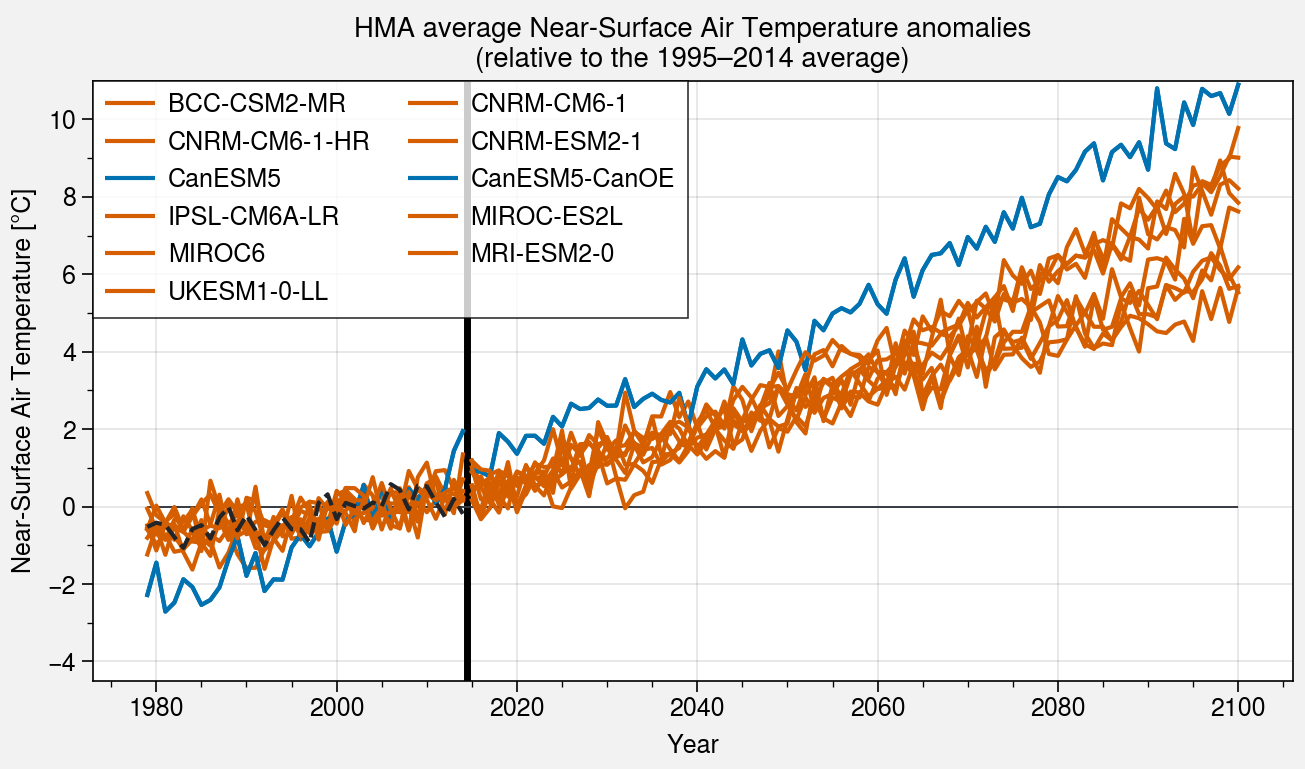

In [53]:
fig, ax = plot.subplots(aspect=2, axwidth=6)

zone = 'HMA'
ymin = -4.5
ymax = 11

#################################
### Compute the climatologies ###
#################################
clim_model = mm_past_ym_zones.sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean()
clim_obs = obs_ym_regrid_zones.sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean()


###################
### Models past ###
###################
h_past = []
for i, model in enumerate(mm_future_ym_zones.model.values):
    
    if model in ['CanESM5', 'CanESM5-CanOE']:
        color='C0' 
    else:
        color='C1'

    clim = mm_past_ym_zones.sel(zone='HMA', season='Annual', model=model, year=slice('1995','2014')).mean()
    anomalies = mm_past_ym_zones.sel(zone='HMA', season='Annual', model=model) - clim
    
    h = ax.plot(anomalies, label=model, color=color)
    h_past.append(h)


    #####################
    ### Models future ###
    #####################
    colors = ['indigo9', 'blue5', 'orange5', 'red6']
    scenarios = ['ssp585']
    h_future = [None]*len(scenarios)

    for i, scenario in enumerate(scenarios):

        clim = mm_past_ym_zones.sel(zone='HMA', season='Annual', model=model, year=slice('1995','2014')).mean()
        anomalies = mm_future_ym_zones.sel(zone='HMA', season='Annual', model=model) - clim

        h_future[i] = ax.plot(anomalies, label=model, color=color)
        
###########
### Obs ###
###########
h_obs = ax.plot(
    (obs_ym_regrid_zones.sel(zone=zone, season=seasons[0]) - clim_obs), 
    label=obs_name, color='gray9', linestyle='--'
)


#############
### Lines ###
#############
ax.vlines(2014.5, ymin, ymax, linewidth=2.5)
ax.hlines(0, 1979, 2100, linewidth=0.7, color='gray8')


#######################
### Legend / Format ###
#######################
ax.legend(h_past, loc='ul', frame=True, ncols=2)

ax.format(
    title='HMA average '+label+' anomalies\n(relative to the 1995–2014 average)', 
    ylabel=label + ' ['+units+']', ylocator=2, yminorlocator=1.00001, ylim=(ymin,ymax),
    xlabel='Year', xminorlocator=5, xlocator=20
)

fig.save('img/CanESM5_tas_projections_ssp585.jpg')

In [12]:
list_models = u.get_model_names_projections()

In [13]:
list_models_2 = list_models
list_models_2

['BCC-CSM2-MR',
 'CESM2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'CanESM5-CanOE',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

In [14]:
list_models_2.remove('CanESM5')
list_models_2.remove('CanESM5-CanOE')

In [15]:
list_models_2

['BCC-CSM2-MR',
 'CESM2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

In [16]:
x = bias.year
y = bias.mean('model').values
stats.linregress(x, y)

NameError: name 'bias' is not defined

In [ ]:
x = bias.year
y = bias.sel(model=list_models_2).mean('model').values
stats.linregress(x, y)